<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/regression_transformations_motivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/pharringtonp19/business-analytics.git

fatal: destination path 'business-analytics' already exists and is not an empty directory.


### **Import Packages**

In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import jax.numpy as jnp
import jax
import seaborn as sb
from functools import partial
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **Read In Data Set**

In [24]:
df = pd.read_csv('/content/business-analytics/datasets/AirPassengers.csv')
df.columns = ['Month', 'Passengers']
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [25]:
# Convert 'Month' to datetime if not already
df['Month_numeric'] = pd.to_datetime(df['Month'])

# Calculate the number of months since the first date
df['Month_Encoded'] = (df['Month_numeric'] - df['Month_numeric'].min()).dt.days // 30

# Min-Max Scaling

df['Month_Encoded_Scaled'] = (df['Month_Encoded'] - df['Month_Encoded'].min()) / (df['Month_Encoded'].max() - df['Month_Encoded'].min())

### **Plot**

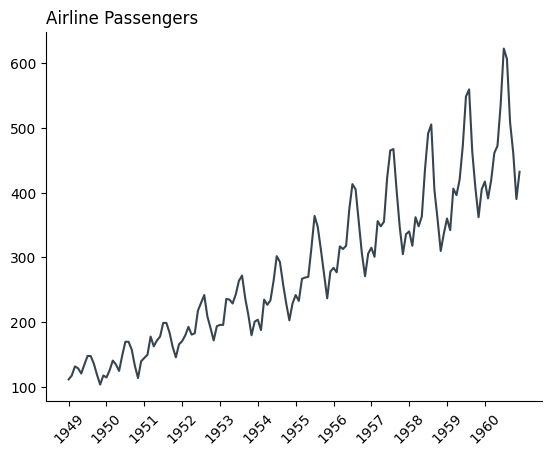

In [26]:
plt.plot(df['Month'], df['Passengers'], color="#36454F")
plt.title('Airline Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
tick_positions = df.index[::12]  # Use the index for positioning
tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability

# Show the plot
plt.show()

In [27]:
def gen_polynomial(k):
    def applyk(x):
        return x**k
    applyk.__name__ = f"x_{k}"
    return applyk

## **Helper Functions**

In [28]:
def apply_transformations(df, variable, list_of_transformations):
  """Treat this as a function defined in another package"""

  # Transformation function
  def transformations(column_name, f):
      return f.__name__, df[column_name].map(f)

  # Apply transformations
  results = list(map(partial(transformations, variable), list_of_transformations))

  # Convert results to a DataFrame with appropriate column names
  transformed_df = pd.DataFrame({key: value for key, value in results})

  # Concatenate original DataFrame with the transformed DataFrame
  df = pd.concat([df, transformed_df], axis=1)

  # Transformed Variable Names
  transformed_variable_names, transformed_columns = zip(*results)
  return df, transformed_variable_names


def create_regression_string(dep_var, transformed_variables):
  if len(transformed_variables) == 1:
    return f'{dep_var} ~ {transformed_variables[0]}'
  return f'{dep_var} ~ {transformed_variables[0] + " + " + " + ".join(transformed_variables[1:])}'

### **Apply Transformations**

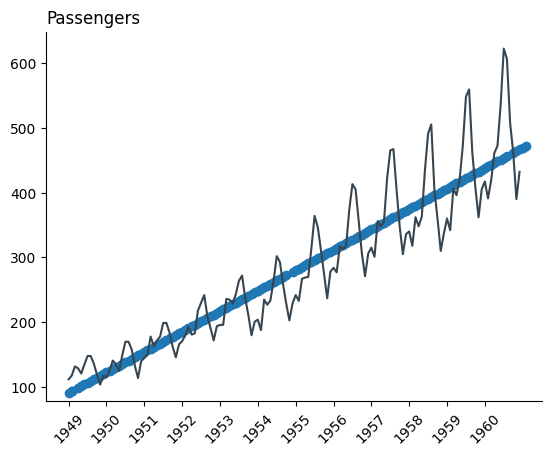

In [29]:
transformations = list(map(gen_polynomial, range(2)))
new_df, transformed_variables = apply_transformations(df, 'Month_Encoded_Scaled', transformations)
regression_string = create_regression_string('Passengers', transformed_variables)
linear_model = smf.ols(regression_string, data=new_df)
results = linear_model.fit()
yhat = results.fittedvalues
plt.scatter(df['Month_Encoded'], yhat)
plt.plot(df['Month'], df['Passengers'], color="#36454F")
plt.title('Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
tick_positions = df.index[::12]  # Use the index for positioning
tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

# Set ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability

# Show the plot
plt.show()

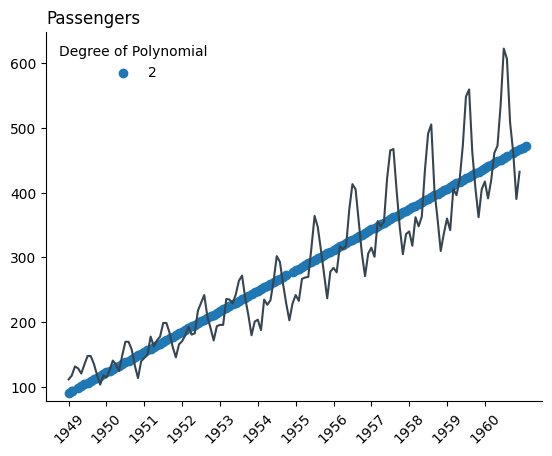

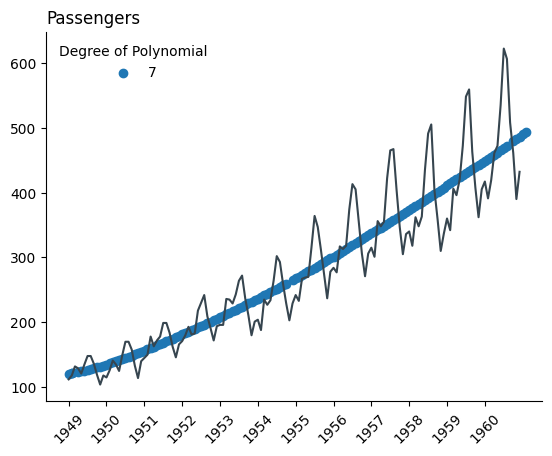

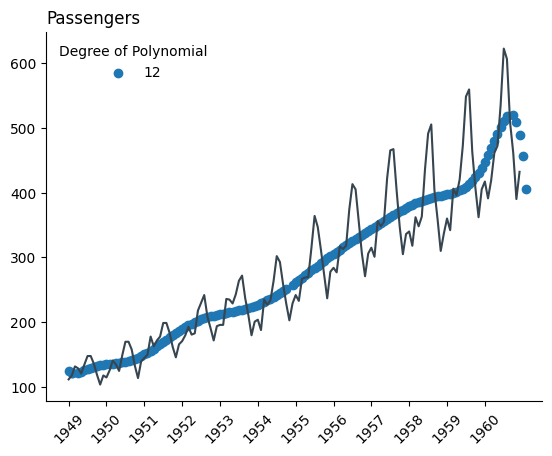

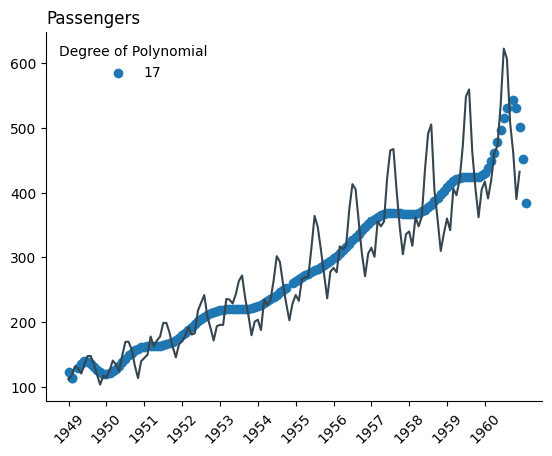

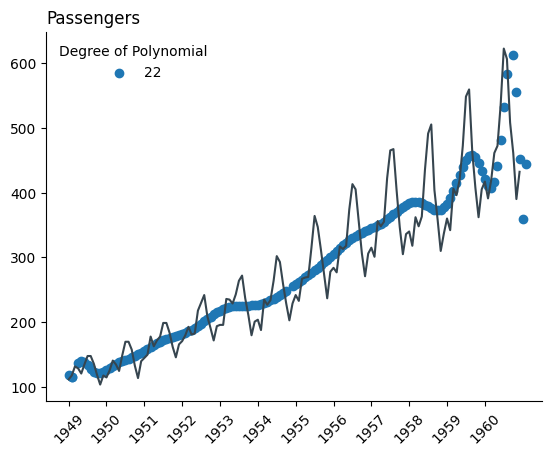

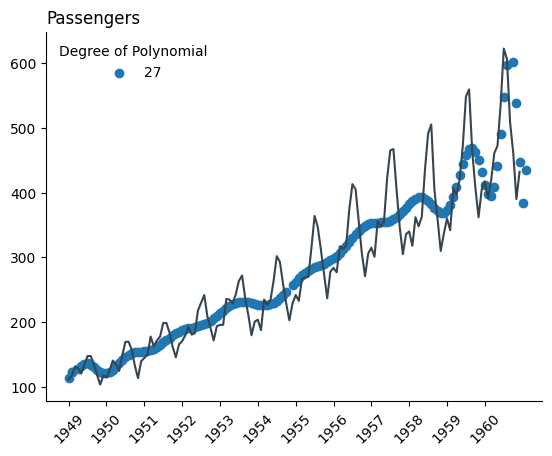

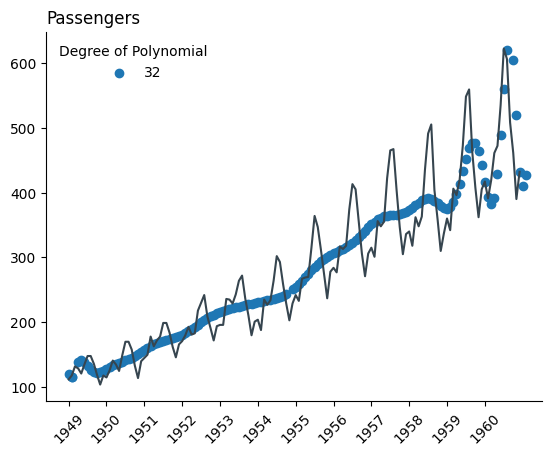

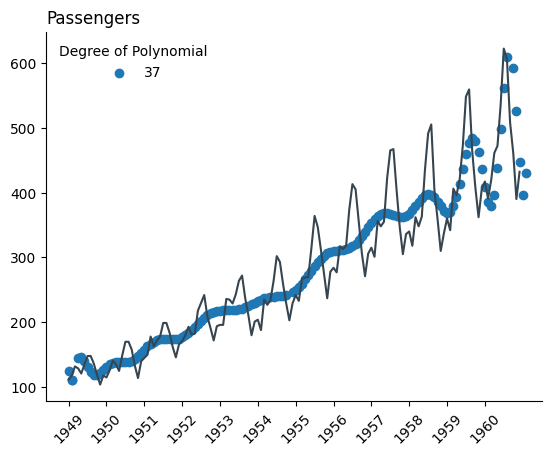

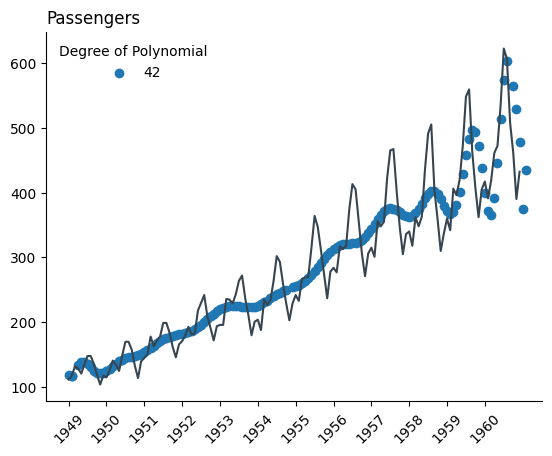

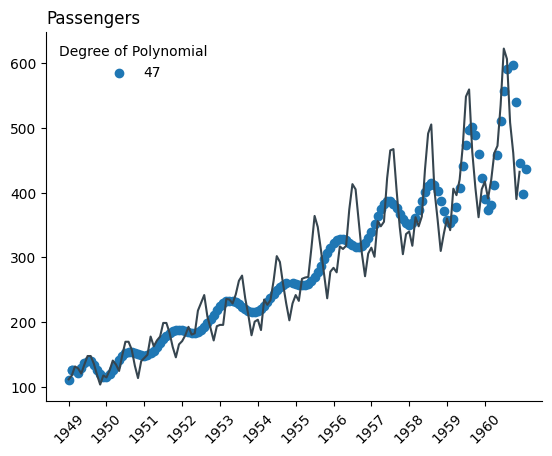

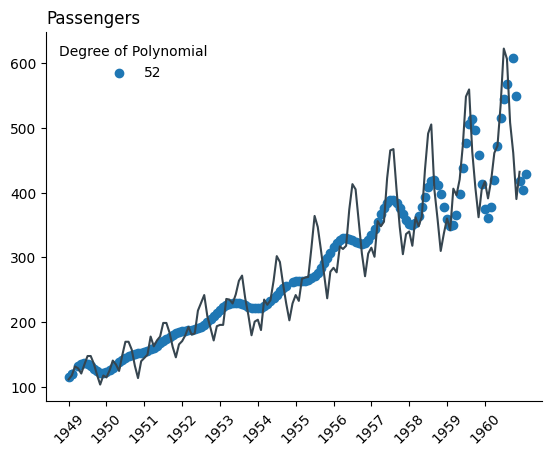

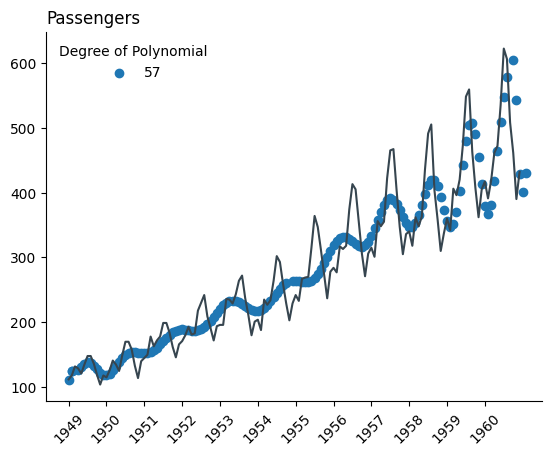

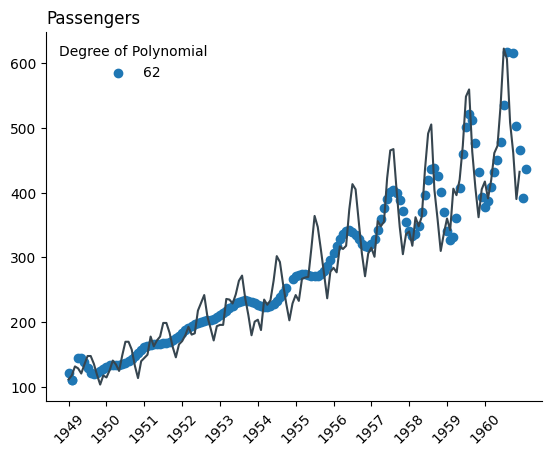

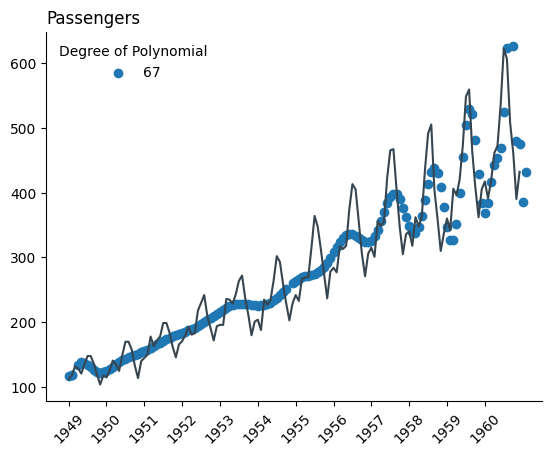

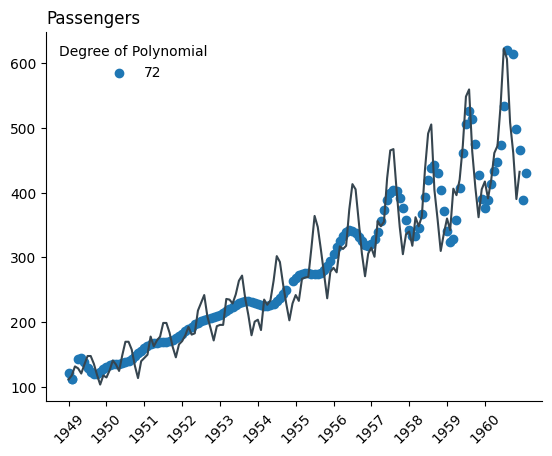

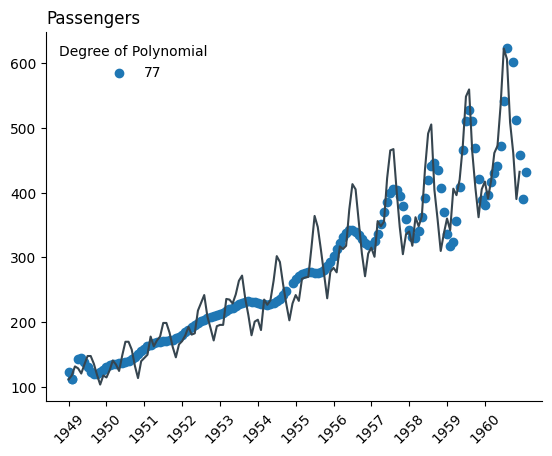

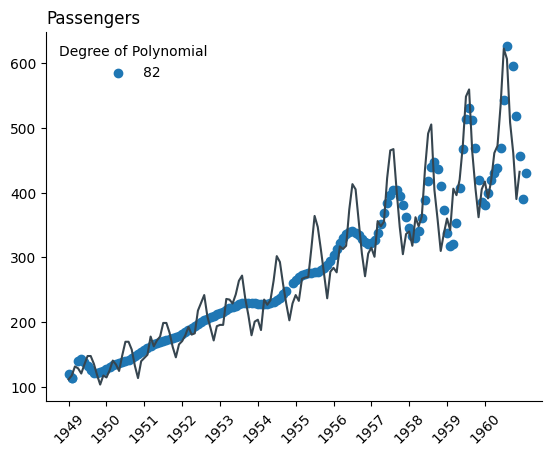

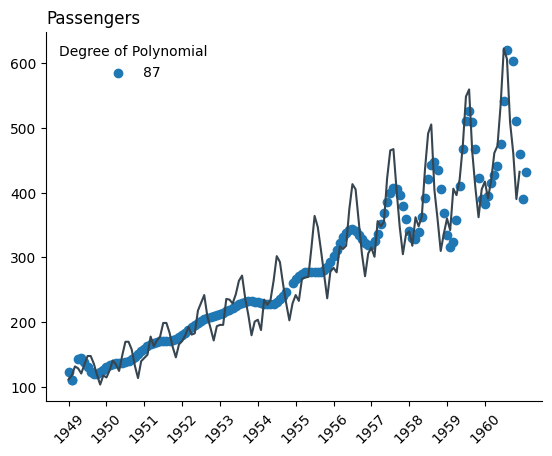

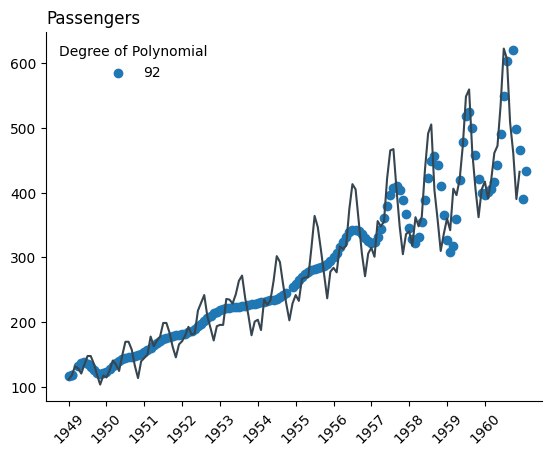

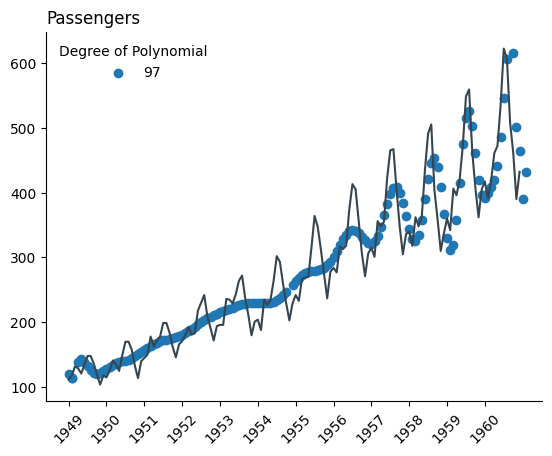

In [30]:
mses = []
Range = range(2, 100, 5)
for i in Range:
  transformations = list(map(gen_polynomial, range(i)))
  new_df, transformed_variables = apply_transformations(df, 'Month_Encoded_Scaled', transformations)
  regression_string = create_regression_string('Passengers', transformed_variables)
  linear_model = smf.ols(regression_string, data=new_df)
  results = linear_model.fit()
  mse = (results.resid**2).mean()
  mses.append(mse)
  yhat = results.fittedvalues

  plt.scatter(df['Month_Encoded'], yhat, label=i)
  plt.plot(df['Month'], df['Passengers'], color="#36454F")
  plt.title('Passengers', loc='left')
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
  tick_positions = df.index[::12]  # Use the index for positioning
  tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

  # Set ticks and labels
  ax.set_xticks(tick_positions)
  ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability
  plt.legend(title='Degree of Polynomial', frameon=False)
  # Show the plot
  plt.show()

### **Mean Squared Error Plot**

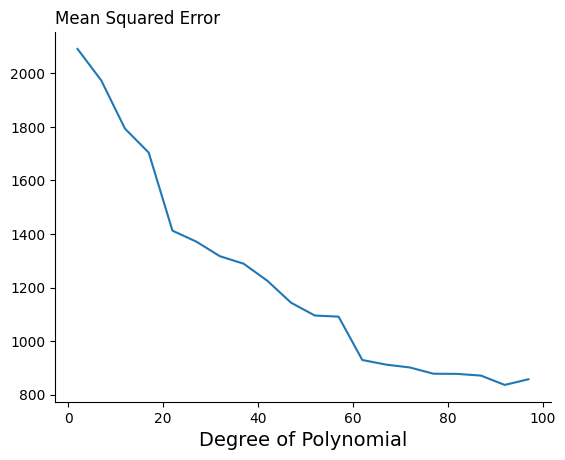

In [31]:
plt.plot(Range, mses)
plt.title('Mean Squared Error', loc='left')
plt.xlabel('Degree of Polynomial', size=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### **Train / Test Split**

In [32]:
cut_id = int(.70*df.shape[0])


### **Simulate**

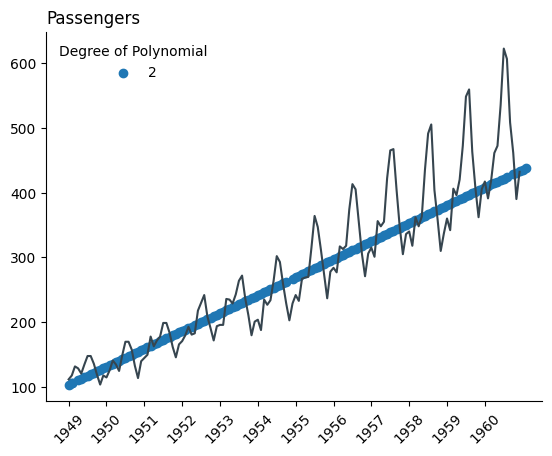

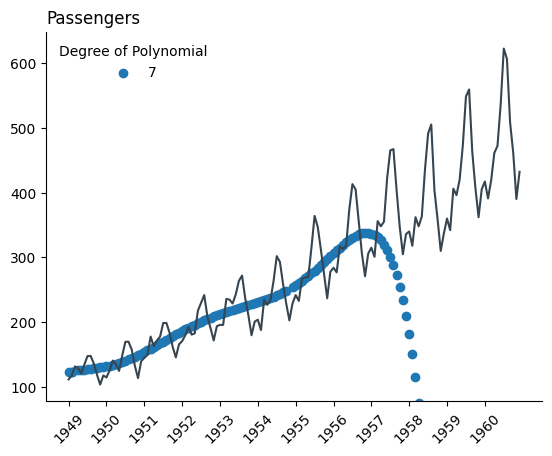

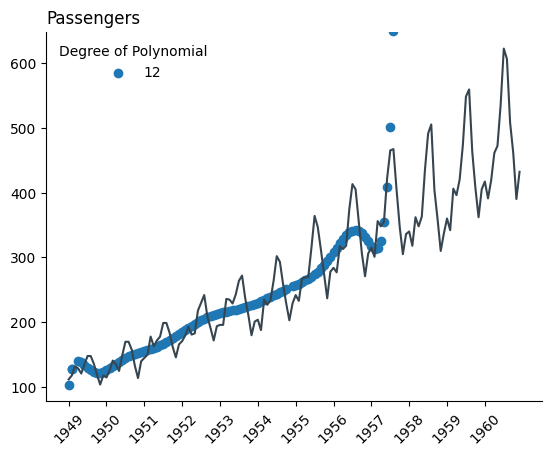

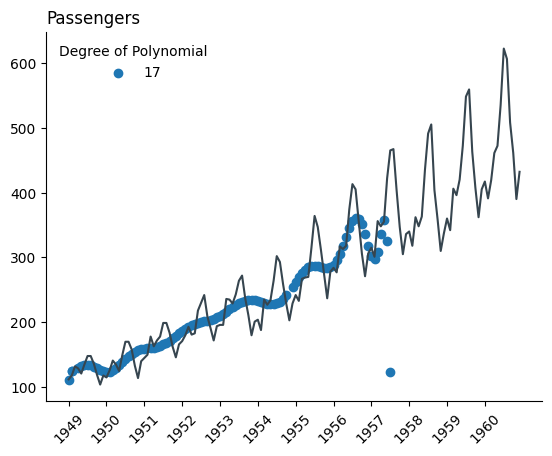

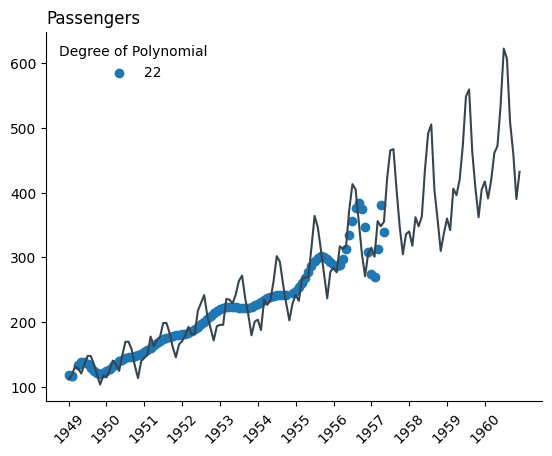

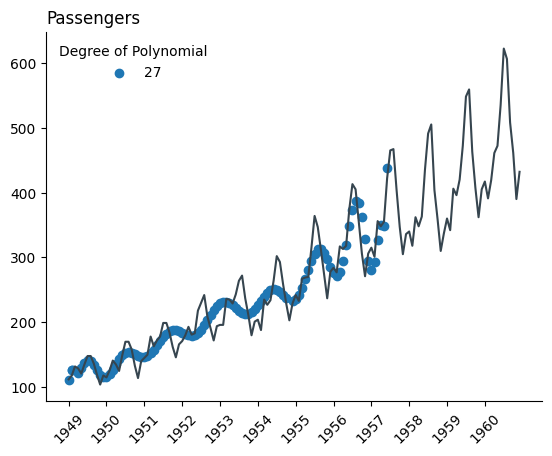

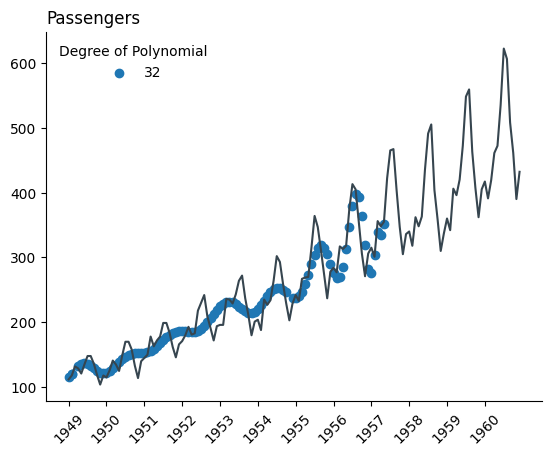

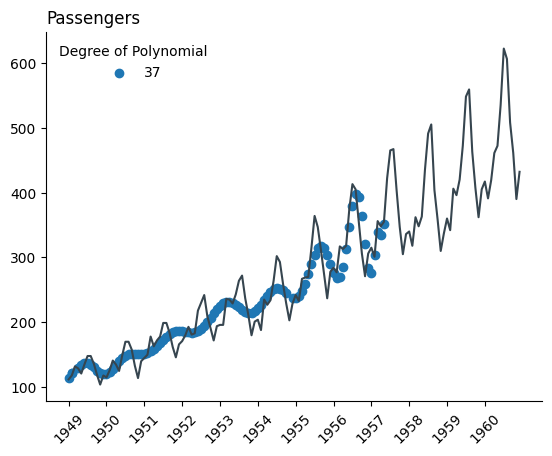

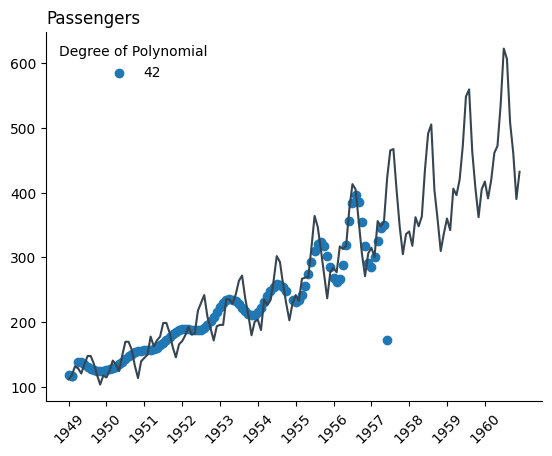

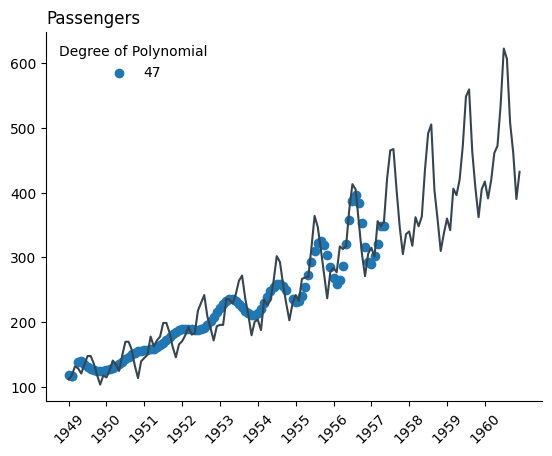

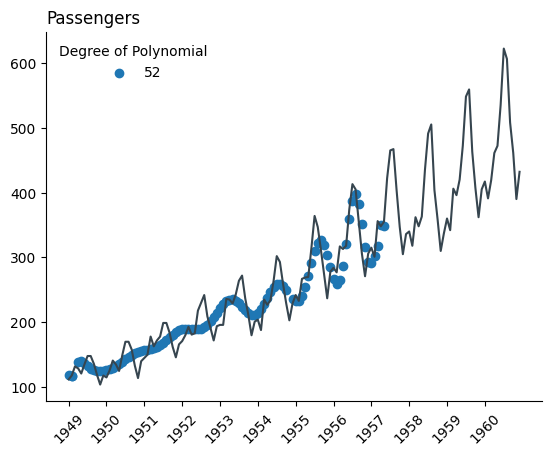

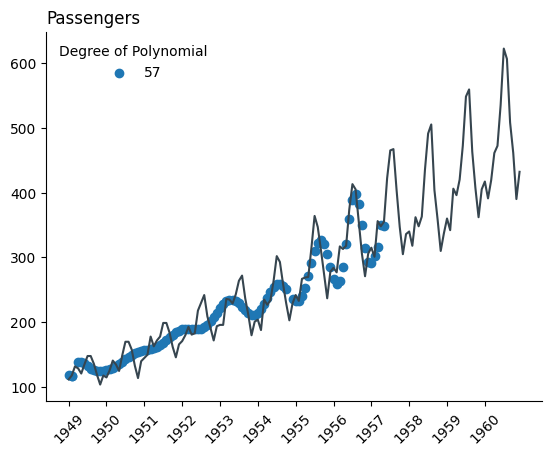

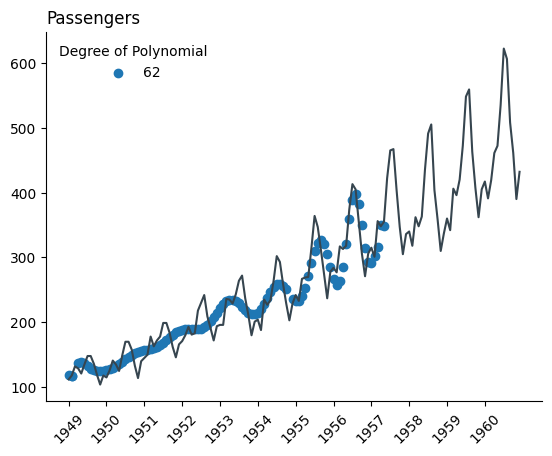

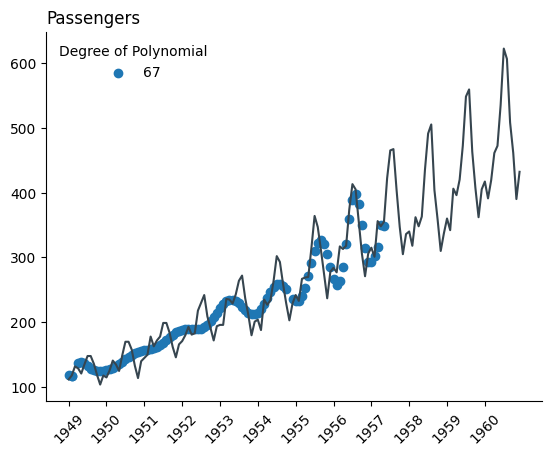

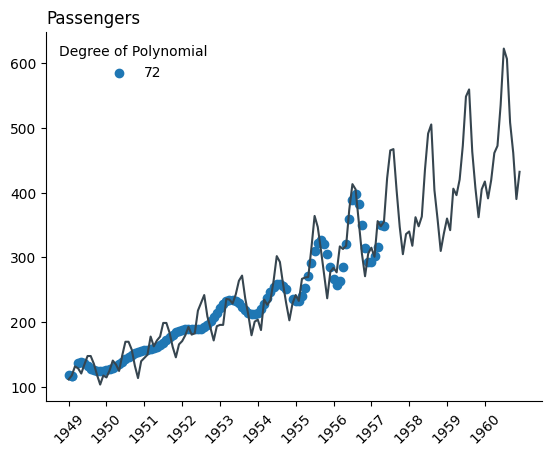

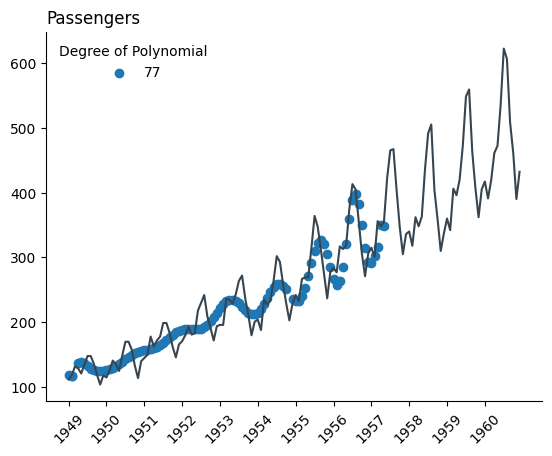

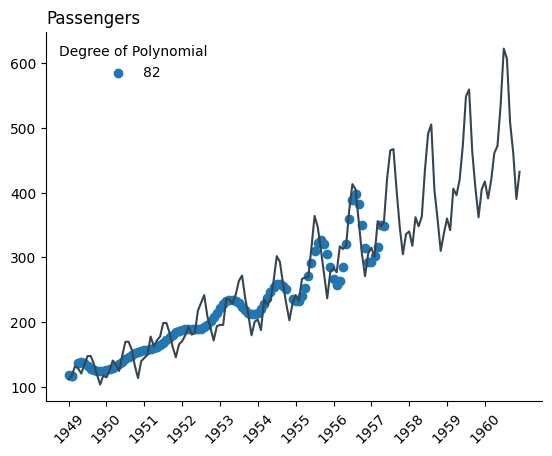

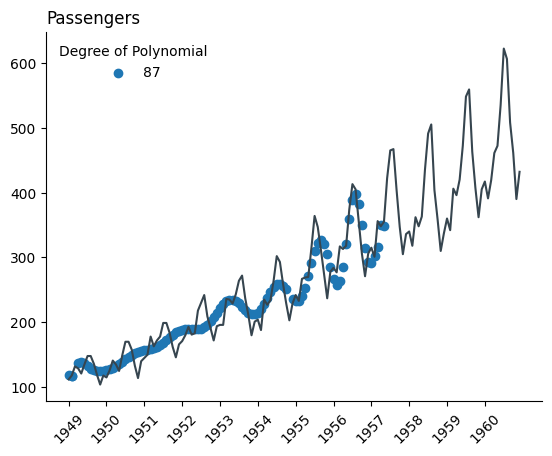

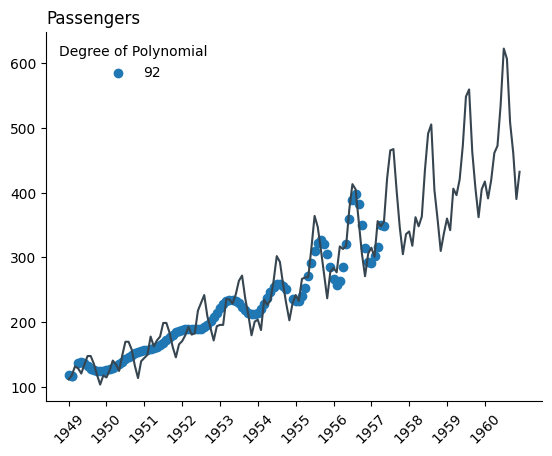

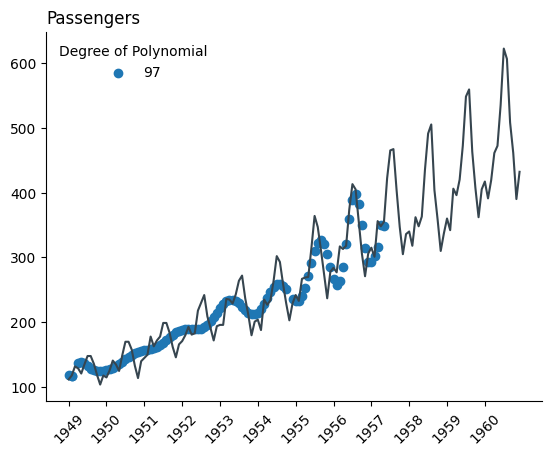

In [39]:
MSES = {'train': [],
        'test': []}
Range = range(2, 100, 5)
for i in Range:
  transformations = list(map(gen_polynomial, range(i)))
  new_df, transformed_variables = apply_transformations(df, 'Month_Encoded_Scaled', transformations)
  new_df_train = new_df.iloc[:cut_id]
  new_df_test = new_df.iloc[cut_id:]
  regression_string = create_regression_string('Passengers', transformed_variables)
  linear_model = smf.ols(regression_string, data=new_df_train)
  results = linear_model.fit()
  in_mse = (results.resid**2).mean()
  out_mse = ((new_df_test['Passengers'] - results.predict(new_df_test))**2).mean()
  MSES['train'].append(in_mse)
  MSES['test'].append(out_mse)
  yhat = results.predict(new_df)

  plt.scatter(new_df['Month_Encoded'], yhat, label=i)
  plt.plot(df['Month'], df['Passengers'], color="#36454F")
  plt.title('Passengers', loc='left')
  ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Select ticks and labels for the x-axis (every 12th month, assuming monthly data)
  tick_positions = df.index[::12]  # Use the index for positioning
  tick_labels = df['Month'][::12].str.split('-').str[0]  # Extract only the year part

  # Set ticks and labels
  ax.set_xticks(tick_positions)
  ax.set_xticklabels(tick_labels, rotation=45)  # Rotate for better readability
  plt.legend(title='Degree of Polynomial', frameon=False)
  # Show the plot
  plt.show()

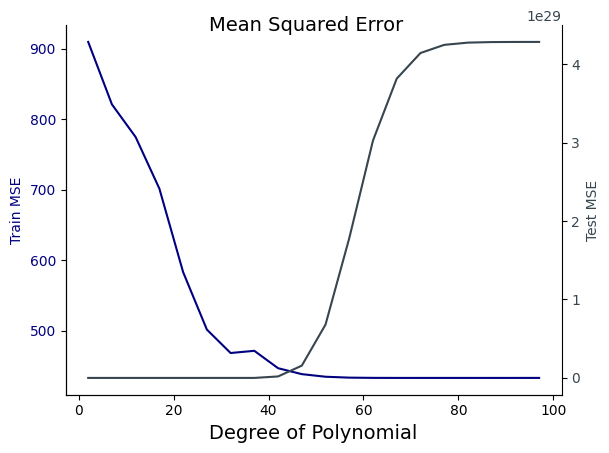

In [43]:
fig, ax1 = plt.subplots()

# Plot the training MSE on the primary y-axis
ax1.plot(Range, MSES['train'], label='Train MSE', color='navy')
ax1.set_xlabel('Degree of Polynomial', size=14)
ax1.set_ylabel('Train MSE', color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(Range, MSES['test'], label='Test MSE', color="#36454F")
ax2.set_ylabel('Test MSE', color="#36454F")
ax2.tick_params(axis='y', labelcolor="#36454F")

# Title and layout adjustments
fig.suptitle('Mean Squared Error', x=0.5, y=0.9, size=14)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()